
## Классификация изображений из датасета [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
### Лузин Владимир Витальевич


## Задание:

Реализовать алгоримтм позволяющий классифицировать изображения из датасета CIFAR-10 и оценить качество его работы.

Требования:

1. Можете придумать свой алгоритм, загрузить готовую модель или использовать собственную архитектуру.

2. Не используйте предобученные модели.

3. Выберите способ оценки качества предсказаний модели. Обоснуйте его.

4. Проведите обучение. Продемонстрируйте умение использовать соответствующие инструменты.

5. Оцените полученный результат.

*Не используйте инструменты принцип работы которых вам непонятен.

### Данные

Установлю  недостающие модули

In [35]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics
!pip install timm

In [2]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import cv2
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models, datasets
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from torchvision.transforms import v2

In [3]:
def seed_everything(seed):
    # Фискирую всё что можно,
    # чтобы исследования можно было воспроизвести
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

Посчитаю среднее и диспервию для датасета

In [4]:
train_dataset = datasets.CIFAR10("content", train=True, download=True, transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]))

100%|██████████| 170498071/170498071 [00:08<00:00, 20339192.52it/s]


Extracting content/cifar-10-python.tar.gz to content


In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))

img, _ = next(iter(train_dataloader))

print(img.mean([0, 2, 3]).tolist())
print(img.std([0, 2, 3]).tolist())


[0.4914010465145111, 0.4821591377258301, 0.44653117656707764]
[0.2470322549343109, 0.24348513782024384, 0.26158785820007324]


Добавление аугментации в данные

In [27]:
train_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.RandomApply([v2.RandomRotation(degrees=15)], p=0.25),
        v2.RandomApply([v2.ColorJitter(brightness=0.05, hue=0.05)], p=0.5),
        v2.RandomApply([v2.RandomEqualize()], p=0.25),
        v2.RandomPerspective(distortion_scale=0.2, p=0.25),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.4914010465145111, 0.4821591377258301, 0.44653117656707764],
                     std=[0.2470322549343109, 0.24348513782024384, 0.26158785820007324])
    ]
)

test_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.4914010465145111, 0.4821591377258301, 0.44653117656707764],
                     std=[0.2470322549343109, 0.24348513782024384, 0.26158785820007324])
    ]
)

train_dataset = datasets.CIFAR10("content", train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10("content", train=False, download=True, transform=test_transform)

# train_dataset = ImageFolder('dataset/dataset/train', transform=train_transform)
# test_dataset = ImageFolder('dataset/dataset/val', transform=test_transform)

BATCH_SIZE = 512

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=6, persistent_workers=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=2, persistent_workers=True)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Посмотрю случайное изображение с аугментацией

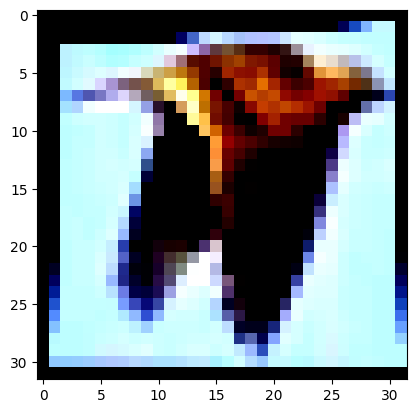

In [29]:
plt.imshow(train_dataset[123][0].permute(1, 2, 0))
plt.show()
# Тут изображение немного повернулось

### Модель

wandb для создания графиков обучения (графики train loss, test loss и top 1 accuracy)

In [8]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu" # device для обучения

Буду обучать модель densenet121 с кастомным классификатором

In [17]:
from torchvision.models import densenet121


class ClassificationNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = densenet121(weights=None)
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor().to(device)
        self.preds = torch.Tensor().to(device)

        # Сделаю промежуточный слой на полтора входных слоя (512), чтобы найти более сложные паттерны
        # И сделаю выход на 10 слоёв. Также добавлю дропауты, и заменю функцию активации
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.25, inplace=True),
            nn.Linear(in_features=in_features,
                      out_features=512, bias=True),
            nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True),
            nn.SiLU(inplace=True),
            nn.Dropout(p=0.25, inplace=True),
            nn.Linear(in_features=512,
                      out_features=10, bias=True),
        )

    def _forward(self, x):
        # runs the Neural Network
        return self.model(x)

    def forward(self, images, target=None):
        images = images.to(device)
        output = self._forward(images)
        loss = None
        if target is not None:
            target = target.to(device)
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target), 0).to(device)
            pred = torch.argmax(output, dim=-1).to(device)
            self.preds = torch.cat((self.preds, pred), 0).to(device)
            self.accuracy = accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=10)

        return loss if target is not None else output

    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

### Обучение

Обучать модель буду с использованием библиотеки Lighting для автоматического обучения и шедулером из библиотеки timm. В качестве оптимайзера возьму Adam, добавляющий инерцию и масштабирование градиента

In [20]:
from timm.scheduler import StepLRScheduler


class ClassificationModule(pl.LightningModule):
    def __init__(self, model, learning_rate, loss):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.loss = loss

    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        # scheduler https://lightning.ai/docs/pytorch/stable/common/optimization.html#bring-your-own-custom-learning-rate-schedulers
        scheduler = StepLRScheduler(optimizer=optimizer, decay_t=5)
        return [optimizer], [{"scheduler": scheduler, "interval": "epoch"}]

    def lr_scheduler_step(self, scheduler, metric):
        scheduler.step(epoch=self.current_epoch)

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        predictions = self(images)
        loss = self.loss(predictions, target)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, test_batch, batch_idx):
        images, target = test_batch
        predictions = self(images)
        # loss
        loss = self.loss(predictions, target)
        # accuracy with softmax
        acc = accuracy(torch.argmax(predictions, dim=-1).long(), target.long(), task="multiclass", num_classes=10)
        # log
        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("accuracy", acc, prog_bar=True, logger=True)
        return loss

In [21]:
model = ClassificationNet().to(device)
# Возьму небольшой шаг и кросс-энтропию в качестве лосса
module = ClassificationModule(model, 0.001, nn.CrossEntropyLoss())

In [22]:
run = wandb.init(project="cifar10")

wandb: Currently logged in as: vldmrl (vldmrl-org). Use `wandb login --relogin` to force relogin


In [23]:
EPOCHS = 20 # 20 Эпох должно хватить. Если что, можно будет дообучить (на деле после 17 эпохи уже пошло переобучения)

In [25]:
wandb_logger = WandbLogger(log_model='all')

Начну обучение

In [30]:
trainer = pl.Trainer(logger=wandb_logger, max_epochs=EPOCHS, accelerator=device)
trainer.fit(module, train_dataloader, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | ClassificationNet | 7.5 M  | train
1 | loss  | CrossEntropyLoss  | 0      | train
----------------------------------------------------
7.5 M     Trainable params
0         Non-trainable params
7.5 M     Total params
29.939    Total estimated m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [31]:
torch.save(module.state_dict(), "module_weights.pth")

### Оценка результата

буду оценивать качество по top 1 accuracy, поскольку для 10 классов брать менее точные метрики не имеет особого смысла

In [32]:
validate_trainer = pl.Trainer(logger=False)
validation = validate_trainer.validate(module, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:516: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:516: You called `self.log('accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.7961000204086304     │
│         val_loss          │    0.6393648386001587     │
└───────────────────────────┴───────────────────────────┘

In [33]:
run.finish()

accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇███▇███
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss,█▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▇▅▄▃▃▃▂▂▂▂▁▁▁▁▁▂▁▁▁
accuracy,0.7961
epoch,19
train_loss,0.41568
trainer/global_step,1959
val_loss,0.63936


In [34]:
acc = validation[0]["accuracy"]
print(f"top 1 accuracy = {acc}")

top 1 accuracy = 0.7961000204086304


## Вывод

В результате получилось не самая точная, но неплохая модель, которая к концу обучения уже начала переобучаться (судя по графикам после 17 эпохи)

Её скорее всего можно было бы улучшить, поменяв модель на более сложную, усложнив классификатор, поменяв аугментацию/шедулер/оптимайзер и поигравшись с гиперпараметрами. Но в задаче не требуется выбивать высокий скор, поэтому оставлю такой вариант